# Sentiment Analysis

This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review. 

We'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers, losses, preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

## Download and Explore IMDB Dataset

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [6]:
dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                 untar=True, cache_dir='.', cache_subdir='')

In [15]:
dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
dataset_dir

'.\\aclImdb'

In [2]:
dataset_dir = os.path.join('.\\', "aclImdb")
dataset_dir

'.\\aclImdb'

In [3]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [5]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [ ]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [7]:
batch_size=32
seed=42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
     batch_size=batch_size,
     validation_split=0.2,
     subset='training',
     seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review: ", text_batch.numpy()[i])
        print("Label: ", label_batch.numpy()[i])

Review:  b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label:  0
Review:  b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get

In [9]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [10]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## Prepare the Dataset

In [12]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />',' ')
    return tf.strings.regex_replace(stripped_html, 
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [13]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
train_text = raw_train_ds.map(lambda x,y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [51]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [54]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'What a lovely heart warming television movie. The story tells of a little five year old girl who has lost her daddy and finds it impossible to cope. Her mother is also very distressed ..only a miracle can alleviate their unhappiness.Which all viewers hope will materialise. Samantha Mathis is brilliant as the little girl\'s mum ,as she was as the nanny in" Jack and Sarah",worth watching if you like both Samantha Mathis and happy; year tear jerking movies! Ellen Burstyn is, as, always a delightful grandmother in this tender and magnificently acted movie. Jodelle Ferland (the little five year old) is charming and a most convincing young actress. The film is based on a true story which makes it so touching."Mermaid" is a tribute to the milk of human kindness which is clearly illustrated and clearly is still all around us in this difficult world we live in. "Mermaid" gives us all hope ,by realising that there a lot of lovely people in the world with lot\'s of love to give

In [56]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  lovely
 313 --->  american
Vocabulary size: 10000


In [57]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Configure the dataset for performance

In [58]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building

In [59]:
embedding_dim = 16

In [106]:
model = tf.keras.Sequential()

In [107]:
model.add(layers.Embedding(max_features + 1, embedding_dim))

In [108]:
model.add(layers.Dropout(0.2))

In [109]:
model.add(layers.GlobalAveragePooling1D())

In [110]:
model.add(layers.Dropout(0.2))

In [111]:
model.add(layers.Dense(1,'sigmoid'))

In [112]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [113]:
model.compile(optimizer='adam', 
              loss = 'binary_crossentropy', metrics = ['accuracy'])

## Train the Model

In [114]:
epochs = 10
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.6641 - accuracy: 0.6899 - val_loss: 0.6149 - val_accuracy: 0.7698
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5481 - accuracy: 0.8026 - val_loss: 0.4982 - val_accuracy: 0.8210
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4438 - accuracy: 0.8456 - val_loss: 0.4202 - val_accuracy: 0.8464
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3777 - accuracy: 0.8657 - val_loss: 0.3740 - val_accuracy: 0.8596
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3350 - accuracy: 0.8784 - val_loss: 0.3452 - val_accuracy: 0.8670
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3038 - accuracy: 0.8893 - val_loss: 0.3265 - val_accuracy: 0.8716
Epoch 7/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2808 - accuracy: 0.8974 - val_loss: 0.3133 - val_accuracy: 0.8732: 0s - 

## Evaluate the Model

In [115]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 1ms/step - loss: 0.3100 - accuracy: 0.8740
Loss:  0.3100476861000061
Accuracy:  0.8740000128746033


Create a plot of accuracy and loss over time

In [116]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [119]:
acc = history_dict['accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc)+1)

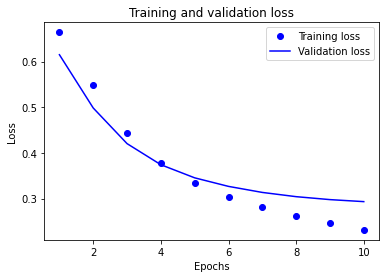

In [120]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

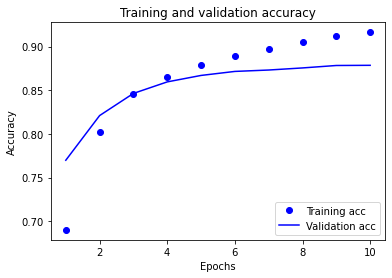

In [121]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Inference on new data

In [124]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

model.predict(examples)

UnimplementedError:  Cast string to float is not supported
	 [[node sequential_2/Cast (defined at <ipython-input-122-9b4beb687ef0>:7) ]] [Op:__inference_predict_function_44072]

Function call stack:
predict_function
